<a href="https://colab.research.google.com/github/google/applied-machine-learning-intensive/blob/master/content/05_deep_learning/05_image_classification_project/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification Project

In this project we will build an image classification model and use the model to identify if the lungs pictured indicate that the patient has pneumonia. The outcome of the model will be true or false for each image.

The [data is hosted on Kaggle](https://www.kaggle.com/rob717/pneumonia-dataset) and consists of 5,863 x-ray images. Each image is classified as 'pneumonia' or 'normal'.

## Ethical Considerations

We will frame the problem as:

> *A hospital is having issues correctly diagnosing patients with pneumonia. Their current solution is to have two trained technicians examine every patient scan. Unfortunately, there are many times when two technicians are not available, and the scans have to wait for multiple days to be interpreted.*
>
> *They hope to fix this issue by creating a model that can identify if a patient has pneumonia. They will have one technician and the model both examine the scans and make a prediction. If the two agree, then the diagnosis is accepted. If the two disagree, then a second technician is brought in to provide their analysis and break the tie.*

Discuss some of the ethical considerations of building and using this model. 

* Consider potential bias in the data that we have been provided. 
* Should this model err toward precision or accuracy?
* What are the implications of massively over-classifying patients as having pneumonia?
* What are the implications of massively under-classifying patients as having pneumonia?
* Are there any concerns with having only one technician make the initial call?

The questions above are prompts. Feel free to bring in other considerations you might have.

### **Student Solution**

Response: Since the model is trained based on human diagnosis of the disease, the training data could contain false positives of pneumonia cases or even false negatives. In addition, it might be more difficult for the model to get less severe or less developed cases of pneumonia. 

Since the model is based on disease diagnosis, it should put accuracy over precision. Since this disease can be life threatening, it’s more important to correctly identify and diagnose patients as soon as possible. 

If patients are over-classified with pneumonia, then many patients may be treated for the disease that they don’t have which could result in some other issues, depending on the effects of the medication or treatments. If people are under classified then it runs the risk of people with the disease not being treated and could lead to the suffering and deaths of the patients. 

Having one technician on the initial call could be an issue if the person relies more on the ;model than their personal judgement. In addition, it takes away the ability for conversation surrounding the x-rays to take place. One technician might be more experienced than another, or one might have more experience with recognizing less severe cases. It would be better to have more than just one technician to ensure the proper care and time is taken into analyzing the x-rays from multiple points of views.

---

## Modeling

In this section of the lab, you will build, train, test, and validate a model or models. The data is the ["Detecting Pneumonia" dataset](https://www.kaggle.com/rob717/pneumonia-dataset). You will build a binary classifier that determines if an x-ray image has pneumonia or not.

You'll need to:

* Download the dataset
* Perform EDA on the dataset
* Build a model that can classify the data
* Train the model using the training portion of the dataset. (It is already split out.)
* Test at least three different models or model configurations using the testing portion of the dataset. This step can include changing model types, adding and removing layers or nodes from a neural network, or any other parameter tuning that you find potentially useful. Score the model (using accuracy, precision, recall, F1, or some other relevant score(s)) for each configuration.
* After finding the "best" model and parameters, use the validation portion of the dataset to perform one final sanity check by scoring the model once more with the hold-out data.
* If you train a neural network (or other model that you can get epoch-per-epoch performance), graph that performance over each epoch.

Explain your work!

> *Note: You'll likely want to [enable GPU in this lab](https://colab.research.google.com/notebooks/gpu.ipynb) if it is not already enabled.*

If you get to a working solution you're happy with and want another challenge, you'll find pre-trained models on the [landing page of the dataset](https://www.kaggle.com/paultimothymooney/detecting-pneumonia-in-x-ray-images). Try to load one of those and see how it compares to your best model.

Use as many text and code cells as you need to for your solution.

### **Student Solution**

## Import Modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import os
import cv2 as cv
from PIL import Image
from random import randrange
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Dataset Preparation

### Downloading Data

In [2]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'

kaggle.json
Done


In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! ls
! unzip chest-xray-pneumonia.zip

### Data Processing

In [35]:
folders = ['test', 'train', 'val']
classes = ['NORMAL', 'PNEUMONIA']
data_base_path = '/content/chest_xray/'

### Folders

In [36]:
train_folder = data_base_path + folders[1]
test_folder = data_base_path + folders[0]
val_folder = data_base_path + folders[2]
print(train_folder)
print(test_folder)
print(val_folder)

/content/chest_xray/train
/content/chest_xray/test
/content/chest_xray/val


### Show Random Pictures

In [37]:
print("Train Pneumonia length: {0}".format(len(os.listdir(train_folder+'/PNEUMONIA'))))
print("Train Normal length: {0}".format(len(os.listdir(train_folder+'/NORMAL'))))

Train Pneumonia length: 3875
Train Normal length: 1341


In [38]:
#random generator for PNEUMONIA
random_P = randrange(0, len(os.listdir(train_folder+'/PNEUMONIA')))
random_N = randrange(0, len(os.listdir(train_folder+'/NORMAL')))

image_P = train_folder + '/' + "PNEUMONIA/" + os.listdir(train_folder+'/PNEUMONIA')[random_P]
image_N = train_folder + '/' + "NORMAL/" + os.listdir(train_folder+'/NORMAL')[random_N]

In [39]:
im = Image.open(train_folder + '/' + "PNEUMONIA/" + os.listdir(train_folder+'/PNEUMONIA')[random_P]) 
im.show()

Text(0.5, 1.0, 'Pneumonia')

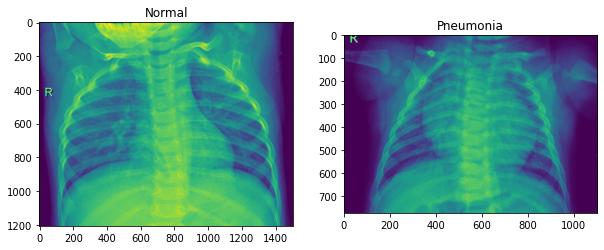

In [40]:
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
read_N = plt.imread(image_N)
img_plot = plt.imshow(read_N)
a1.set_title('Normal')


a2 = f.add_subplot(1, 2, 2)
read_P = plt.imread(image_P)
img_plot = plt.imshow(read_P)
a2.set_title('Pneumonia')

### Model 1

In [46]:
cnn = Sequential([
  #Convolution
  Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
  #Pooling
  MaxPooling2D(pool_size = (2, 2)),
  # 2nd Convolution
  Conv2D(32, (3, 3), activation="relu"),
  # 2nd Pooling layer
  MaxPooling2D(pool_size = (2, 2)),
  # Flatten the layer
  Flatten(),
  # Fully Connected Layers
  Dense(activation = 'relu', units = 128),
  Dense(activation = 'sigmoid', units = 1)
])

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Model 2

In [82]:
cnn = Sequential([
  #Convolution
  Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
  #Pooling
  MaxPooling2D(pool_size = (2, 2)),
  # 2nd Convolution
  Conv2D(32, (3, 3), activation="relu"),
  Conv2D(32, (3, 3), activation="relu"),
  # 2nd Pooling layer
  MaxPooling2D(pool_size = (2, 2)),
  # Flatten the layer
  Flatten(),
  # Fully Connected Layers
  Dense(activation = 'relu', units = 128),
  Dense(activation = 'sigmoid', units = 1)
])

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

### Model 3

In [71]:
cnn = Sequential([
  #Convolution
  Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
  #Pooling
  MaxPooling2D(pool_size = (2, 2)),
  MaxPooling2D(pool_size = (2, 2)),
  # 2nd Convolution
  Conv2D(32, (3, 3), activation="sigmoid"),
  Conv2D(32, (3, 3), activation="relu"),
  # 2nd Pooling layer
  MaxPooling2D(pool_size = (2, 2)),
  # Flatten the layer
  Flatten(),
  # Fully Connected Layers
  #Dense(activation = 'relu', units = 128),
  Dense(activation = 'sigmoid', units = 1)
])

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)              

In [49]:
# num_of_test_samples = 600
# batch_size = 32

In [83]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory(train_folder, target_size = (64, 64), batch_size = 32, class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(val_folder, target_size=(64, 64), batch_size=32, class_mode='binary')

test_set = test_datagen.flow_from_directory(test_folder, target_size = (64, 64), batch_size = 32, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [84]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [85]:
history = cnn.fit(training_set, steps_per_epoch = 163, epochs = 10, validation_data = validation_generator, validation_steps = 624)

Epoch 1/10
163/163 [==============================] - 52s 315ms/step - loss: 0.4240 - accuracy: 0.8123 - val_loss: 0.7473 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 50s 308ms/step - loss: 0.2357 - accuracy: 0.9050
Epoch 3/10
163/163 [==============================] - 50s 306ms/step - loss: 0.2308 - accuracy: 0.9042
Epoch 4/10
163/163 [==============================] - 51s 310ms/step - loss: 0.1723 - accuracy: 0.9313
Epoch 5/10
163/163 [==============================] - 51s 313ms/step - loss: 0.1739 - accuracy: 0.9324
Epoch 6/10
163/163 [==============================] - 51s 312ms/step - loss: 0.1709 - accuracy: 0.9292
Epoch 7/10
163/163 [==============================] - 51s 311ms/step - loss: 0.1698 - accuracy: 0.9337
Epoch 8/10
163/163 [==============================] - 51s 312ms/step - loss: 0.1481 - accuracy: 0.9424
Epoch 9/10
163/163 [==============================] - 50s 306ms/step - loss: 0.1319 - accuracy: 0.9541
Epoch 10/10
163/163 [==========

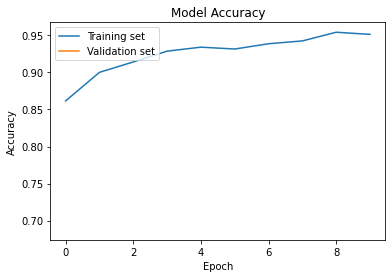

In [86]:
# Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

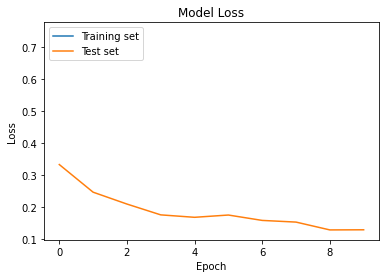

In [87]:
# Loss 
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [88]:
predictions = cnn.predict(test_set)

In [89]:
predictions[-1]

array([0.99713457], dtype=float32)

In [90]:
eval = cnn.evaluate(test_set)
eval

20/20 [==============================] - 5s 253ms/step - loss: 0.3076 - accuracy: 0.9038


[0.3076263666152954, 0.9038461446762085]

In [91]:
val = cnn.predict(validation_generator)

In [92]:
val[-1]

array([0.96649384], dtype=float32)